In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import sklearn
from helpers import *

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [4]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [5]:
actors = actors_load.copy()
movies = movies_load.copy()

In [6]:
actors_exp = explode_on_movies(actors)

In [7]:
# Merge actors_exp DataFrame with selected columns from movies DataFrame and sort chronologically
actors_movies = actors_exp.merge(
    movies[["fbID", "genres", "releaseMonth", "releaseYear"]], how="left", on="fbID"
)
actors_movies_sort = actors_movies.sort_values(
    by=["fbActorID", "ageAtMovieRelease", "releaseYear", "releaseMonth"]
)

# Filter actors with at least 20 movies
actors_min_movies = actors_movies_sort.query("numMovies >= 20")

# Remove rows where both ageAtMovieRelease and releaseYear are NaN and where genres is NaN
actors_filter = actors_min_movies[
    ~(actors_min_movies.ageAtMovieRelease.isna() & actors_min_movies.releaseYear.isna())
    & ~actors_min_movies.genres.isna()
].copy()

# Create a new column "genresLen" representing the number of the genres for each movie
actors_filter["genresLen"] = actors_filter.genres.apply(lambda x: len(x))

actors_filter["LastMovie"] = np.array(
    [*(actors_filter.fbActorID[1:].values != actors_filter.fbActorID.values[:-1]), True]
)
# Create a new column "LastMovie" indicating whether it's the last movie for each actor

# Get list of genres in order of occurrences
genreslist = actors_filter.genres.explode().value_counts().index

# Create a new DataFrame 'df_genres' containing genre columns and reset index to be able to iterate
df_genres = actors_filter[["genres", "genresLen", "LastMovie"]].reset_index(
    drop=True
)

# Count the occurrences of genres in movies that are not the last for each actor
genres_counts = df_genres[~df_genres["LastMovie"]].genres.explode().value_counts()

# Create a dictionary mapping genres to their corresponding index based on their order of occurrences
index_genres = dict(zip(genres_counts.index, np.arange(len(genreslist))))

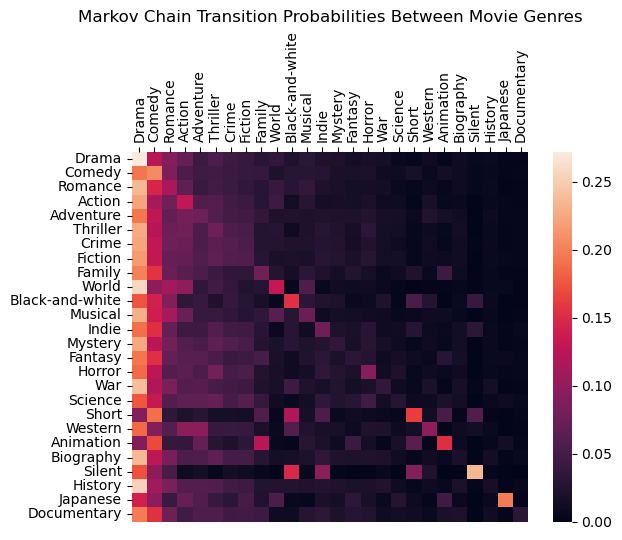

In [8]:
# Initialize a square matrix M to represent the Markov chain transition probabilities
M = np.zeros((len(index_genres), len(index_genres)))

# Iterate through rows of df_genres
for index, row in df_genres.iterrows():
    # Check if it's not the last movie for the actor
    if not row["LastMovie"]:
        for genres_i in row["genres"]:
            for genres_j in df_genres["genres"].iloc[index + 1]:
                # Increment the transition probability
                M[index_genres[genres_i], index_genres[genres_j]] += 1 / (row["genresLen"] * df_genres["genresLen"].iloc[index + 1])
                    

# Normalize to represent a Markov chain
M = np.divide(M, M.sum(axis=1)[:, np.newaxis])

# Plot a heatmap of the Markov chain transition matrix
heatmap_ax = sns.heatmap(
    M,
    xticklabels=genreslist,
    yticklabels=genreslist,
)
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.title("Markov Chain Transition Probabilities Between Movie Genres");

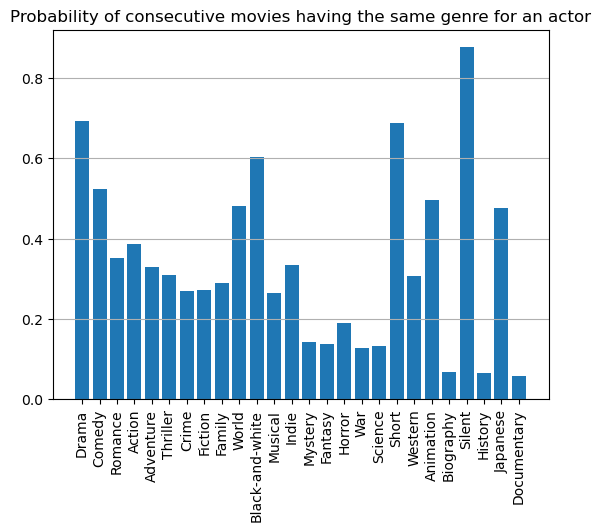

In [9]:
# Initialize an array to track the number of times each genre is kept by an actor for two consecutive movies
genre_kept = np.zeros(len(genreslist))

for index, row in df_genres.iterrows():
    # Check if it's not the last movie for the actor
    if not row["LastMovie"]:
        # Find the intersection of genres between the current and next movie
        genre_intersection = row["genres"].intersection(
            df_genres["genres"].iloc[index + 1]
        )
        # If there is an intersection, update genre_kept array
        if len(genre_intersection) != 0:
            for genre in genre_intersection:
                genre_kept[index_genres[genre]] += 1

# Plot a bar chart showing the proportion of each genre kept
plt.figure()
plt.bar(genreslist, genre_kept / genres_counts)
plt.xticks(rotation=90)
plt.title("Probability of consecutive movies having the same genre for an actor")
plt.grid(axis="y")

In [10]:
# Filter out rows where genres are not NaN and count genres for each movies
actors_genres = actors_min_movies[~actors_min_movies.genres.isna()].copy()
actors_genres["genresLen"] = actors_genres.genres.apply(lambda x: len(x))
actors_genres["LastMovie"] = np.array(
    [*(actors_genres.fbActorID[1:].values != actors_genres.fbActorID.values[:-1]), True]
)

# Explode the genres column to create separate rows for each genre
exploded_actors_genres = actors_genres.explode("genres")

# Create dummy variables for genres using one-hot encoding
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Group by fbActorID and aggregate data, summing up occurrences of each genre
actor_genre_counts = (
    genre_dummies
    .groupby("fbActorID")
    .agg({"fbID": lambda x: np.unique(x), **{genre: "sum" for genre in genreslist}})
)

# Calculate the number of movies with genre for each actor 
actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# Calculate the proportion of each genre for each actor
actor_genre_proportion = actor_genre_counts[genreslist].div(
    actor_genre_counts["numMoviesWithGenre"], axis=0
)

actor_genre_proportion

,Drama,Comedy,Romance,Action,Adventure,Thriller,Crime,Fiction,Family,World,...,War,Science,Short,Western,Animation,Biography,Silent,History,Japanese,Documentary
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.807692,0.134615,0.230769,0.423077,0.538462,0.192308,0.230769,0.230769,0.115385,0.096154,...,0.192308,0.038462,0.000000,0.153846,0.038462,0.057692,0.00,0.076923,0.000000,0.000000
/m/0112yl,0.875000,0.187500,0.083333,0.500000,0.458333,0.166667,0.166667,0.208333,0.000000,0.541667,...,0.125000,0.000000,0.000000,0.020833,0.000000,0.020833,0.00,0.083333,0.750000,0.000000
/m/011_3s,0.407407,0.888889,0.148148,0.074074,0.148148,0.111111,0.148148,0.148148,0.296296,0.037037,...,0.037037,0.037037,0.000000,0.000000,0.111111,0.000000,0.00,0.037037,0.037037,0.000000
/m/011_nf,0.750000,0.333333,0.416667,0.111111,0.194444,0.055556,0.166667,0.111111,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.083333,0.000000,0.027778,0.25,0.027778,0.000000,0.000000
/m/011_pk,0.843750,0.250000,0.343750,0.250000,0.156250,0.187500,0.500000,0.406250,0.000000,0.000000,...,0.062500,0.000000,0.000000,0.031250,0.000000,0.031250,0.00,0.031250,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0tj9,0.772973,0.302703,0.356757,0.459459,0.200000,0.156757,0.167568,0.118919,0.151351,0.621622,...,0.016216,0.005405,0.005405,0.005405,0.000000,0.005405,0.00,0.016216,0.000000,0.005405
/m/0ywqc,0.684685,0.306306,0.135135,0.288288,0.243243,0.405405,0.279279,0.306306,0.036036,0.045045,...,0.135135,0.099099,0.009009,0.018018,0.018018,0.063063,0.00,0.054054,0.027027,0.036036
/m/0z05l,0.777778,0.370370,0.185185,0.259259,0.518519,0.222222,0.185185,0.259259,0.185185,0.000000,...,0.074074,0.074074,0.000000,0.259259,0.000000,0.148148,0.00,0.037037,0.037037,0.000000


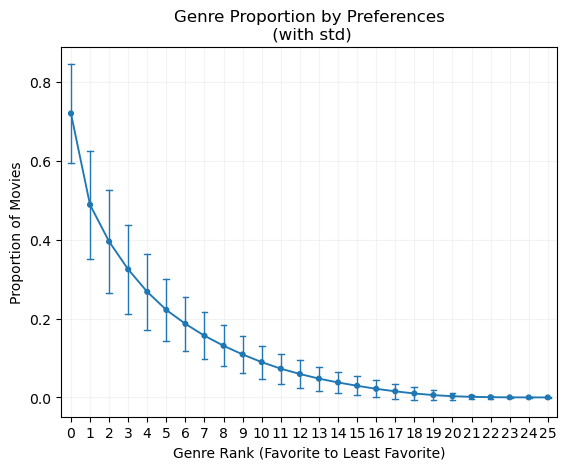

In [11]:
# Sort genres for each actor from favorite to least favorite
actor_genre_proportion_arr = actor_genre_proportion.to_numpy()
genre_favorites_prop=np.sort(actor_genre_proportion_arr, axis=1)[:, ::-1]

sns.pointplot(
    data=genre_favorites_prop,
    errorbar="sd",  # Show error bars based on standard deviation
    scale=0.5,
    capsize=0.3,
    errwidth=1,
)
plt.title("Genre Proportion by Preferences\n (with std)")
plt.xlabel("Genre Rank (Favorite to Least Favorite)")
plt.ylabel("Proportion of Movies")
plt.grid(alpha=0.15)
plt.show()

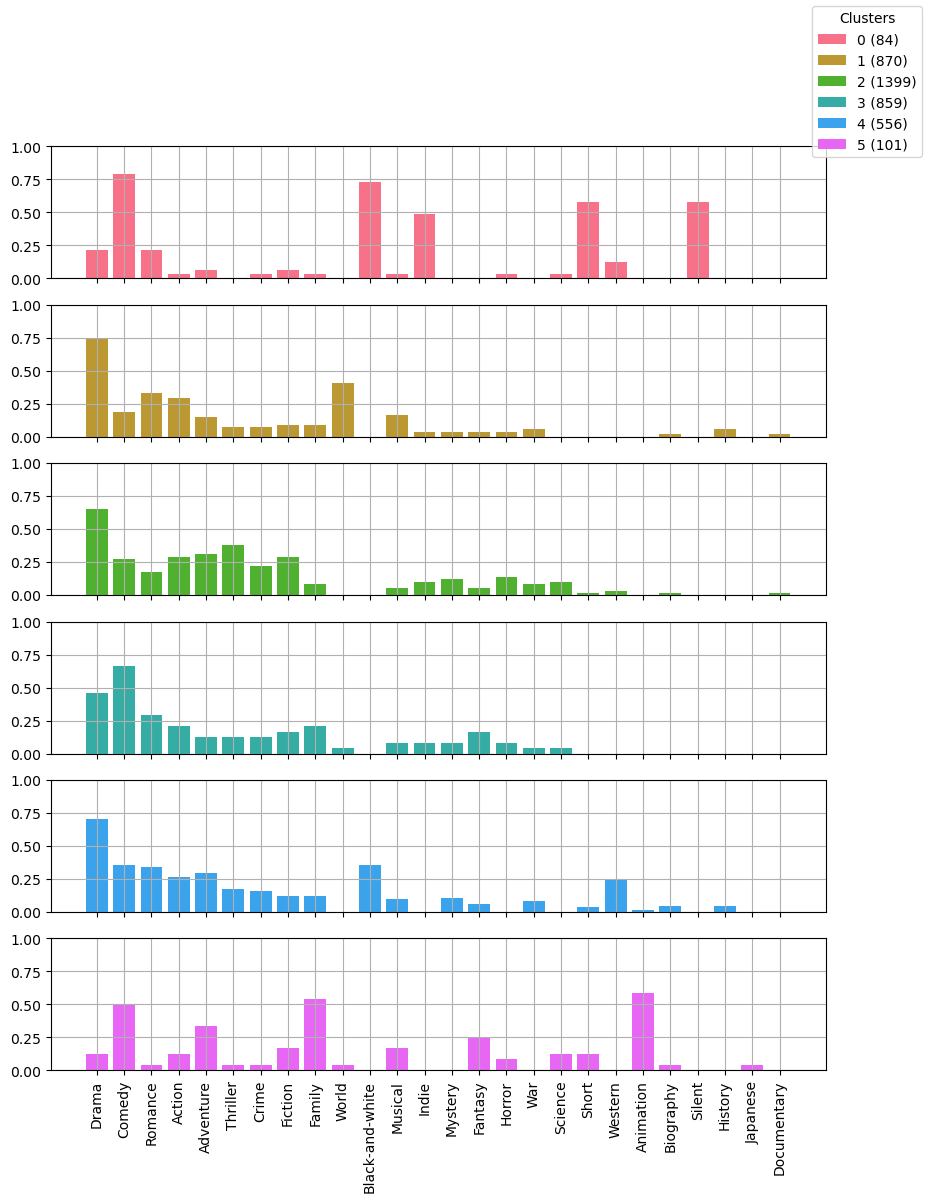

In [26]:
kmeans = KMeans(n_clusters=6, n_init=10,random_state=1).fit(actor_genre_proportion_arr)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(actor_genre_proportion_arr, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = actor_genre_proportion_arr[cluster_medoids]

fig, axes = plt.subplots(len(medoid_profile_sequences), 1, sharex=True, figsize=(10, 12))

colors = sns.color_palette("husl", n_colors=medoid_profile_sequences.shape[0])
for i in range(medoid_profile_sequences.shape[0]):
    axes[i].bar(
        np.arange(len(genreslist)), medoid_profile_sequences.T[:, i], color=colors[i]
    )
    axes[i].set_xticks(np.arange(len(genreslist)))
    axes[i].set_xticklabels(genreslist, rotation=90)
    axes[i].grid()
    axes[i].set_ylim(0, 1)


fig.legend(
    [
        f"{c} ({l})"
        for c, l in zip(
            *np.unique(kmeans.predict(actor_genre_proportion_arr), return_counts=True)
        )
    ],
    title="Clusters",
)
plt.show()

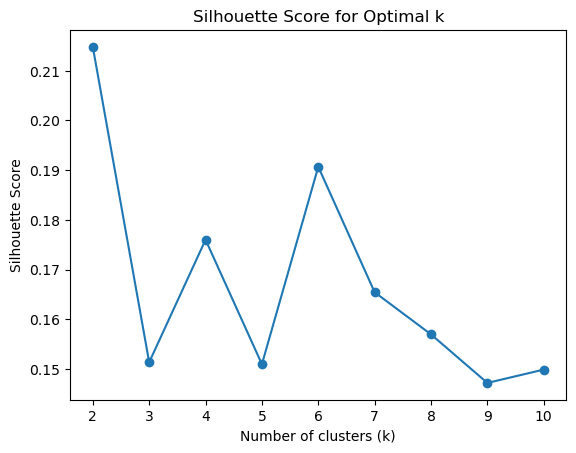

In [22]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(actor_genre_proportion_arr)
    silhouette_scores.append(silhouette_score(actor_genre_proportion_arr, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Normalisé

In [14]:
exploded_actors_genres

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,genres,releaseMonth,releaseYear,genresLen,LastMovie
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,Crime,NaN,1959.0,5,False
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,Thriller,NaN,1959.0,5,False
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,Adventure,NaN,1959.0,5,False
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,Drama,NaN,1959.0,5,False
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,Action,NaN,1959.0,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446023,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0k3lpxc,46.0,None,None,54,Drama,NaN,2014.0,1,False
445980,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/03cv_gy,NaN,None,None,54,Fiction,NaN,NaN,2,False
445980,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/03cv_gy,NaN,None,None,54,War,NaN,NaN,2,False
446010,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0ck650,NaN,None,None,54,Family,NaN,NaN,2,True


Text(0, 0.5, 'Frequency')

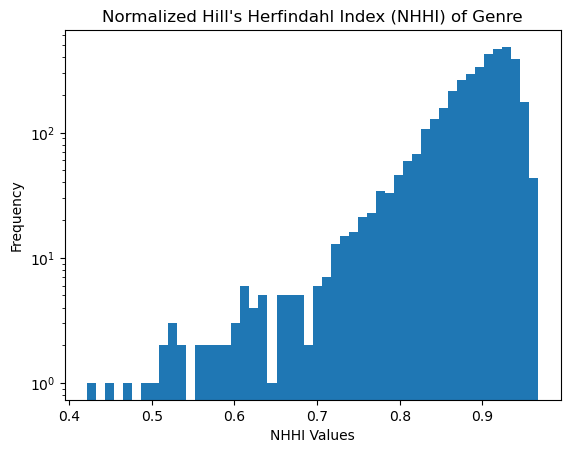

In [15]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID", "LastMovie"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Normalize genre occurrences by dividing each genre count by the total number of genres in movies
genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

# Group by actor and aggregate data, summing up occurrences of each genre
actor_genre_counts = genre_dummies.groupby("fbActorID").agg(
    {"fbID": lambda x: np.unique(x), **{genre: "sum" for genre in genreslist}}
)

# Calculate the number of movies with genres for each actor 
actor_genre_counts["numMoviesWithGenre"] = actor_genre_counts.fbID.apply(lambda x: len(x))

# Calculate the percentage of each genre for each actor 
actor_genre_percentage = actor_genre_counts[genreslist].div(
    actor_genre_counts["numMoviesWithGenre"], axis=0
)

# Convert the actor_genre_percentage DataFrame to numpy arrays for further calculations
genres_perc = actor_genre_percentage.to_numpy()
num_genres_explored = np.count_nonzero(actor_genre_percentage,axis=1)

# Calculate Normalized Hill's Herfindahl Index (NHHI) to measure diversity in genre preferences
NHHI = 1 - ((genres_perc**2).sum(axis=1) - 1 /len(genreslist)) / (1 - 1 /len(genreslist))


plt.hist(NHHI, bins=50)
plt.yscale("log")
plt.title("Normalized Hill's Herfindahl Index (NHHI) of Genre")
plt.xlabel("NHHI Values")
plt.ylabel("Frequency")

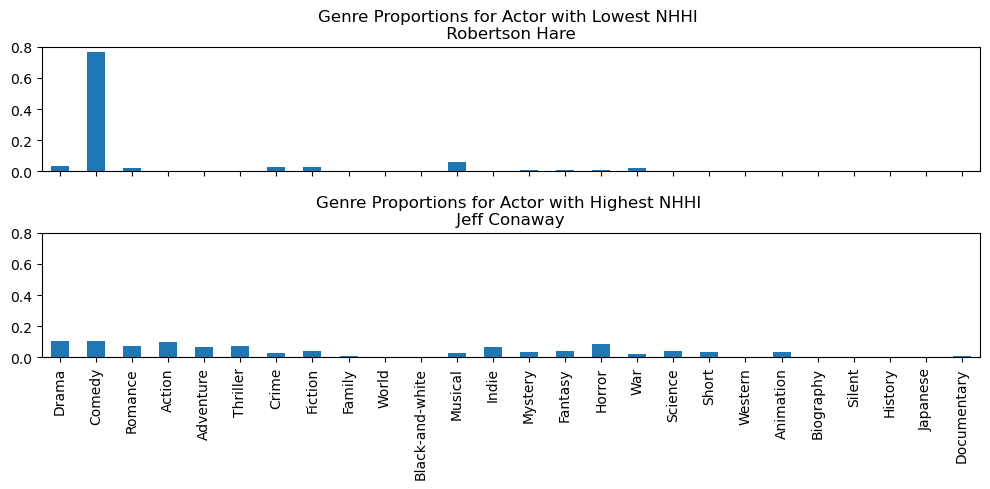

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot genre proportions for the actor with the lowest NHHI value
actor_genre_percentage.iloc[np.argmin(NHHI)].plot(kind="bar", ax=ax1)
ax1.set_ylim(0, 0.8)
ax1.set_title(
    f"Genre Proportions for Actor with Lowest NHHI \n {actors[actors['fbActorID']==actor_genre_percentage.iloc[np.argmin(NHHI)].name].actorName.item()} "
)

# Plot genre proportions for the actor with the highest NHHI value
actor_genre_percentage.iloc[np.argmax(NHHI)].plot(kind="bar", ax=ax2)
ax2.set_ylim(0, 0.8)
ax2.set_title(
    f"Genre Proportions for Actor with Highest NHHI \n {actors[actors['fbActorID']==actor_genre_percentage.iloc[np.argmax(NHHI)].name].actorName.item()} "
)
ax2.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

In [18]:
# Group by fbActorID and aggregate data, summing up occurrences of each genre
actor_genre_counts = (
    genre_dummies
    .groupby(["fbActorID", "fbID", "LastMovie"], sort=False)
    .agg({genre: "sum" for genre in genreslist})
)

actor_genre_counts= actor_genre_counts.reset_index(level="LastMovie")

actor_genre_counts["numMovieWithGenre"] = np.ones(len(actor_genre_counts)).astype(int)

actor_genre_cum = actor_genre_counts.groupby(
            actor_genre_counts["LastMovie"].shift(1, fill_value=0).cumsum(),
        ).cumsum()

actor_genre_cum["NHHI"] = (1 - (
    (
        (actor_genre_cum[genreslist]).div(actor_genre_cum["numMovieWithGenre"], axis=0)
        ** 2
    ).sum(axis=1)
    - 1 / len(genreslist)
) / (1 - 1 / len(genreslist))).astype(float)

actor_NHHI = actor_genre_cum.drop(columns=[*genreslist,"LastMovie"])

actor_NHHI_20 = actor_NHHI.query("numMovieWithGenre<=50")

actor_NHHI_20.reset_index()

NHHI_series = (
    actor_NHHI_20.droplevel("fbID")
    .reset_index()
    .pivot_table(index="fbActorID", columns="numMovieWithGenre", values="NHHI")
)

NHHI_series

numMovieWithGenre,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.832000,0.845000,0.867822,0.878150,0.888576,0.897867,0.902324,0.863633,0.891661,0.896688,...,0.918955,0.918003,0.917075,0.917227,0.919986,0.921249,0.915025,0.918120,0.921093,0.919277
/m/0112yl,0.866667,0.845000,0.876296,0.877113,0.888917,0.885557,0.879030,0.887997,0.891530,0.897123,...,0.899451,0.897303,0.899989,0.899261,0.901383,0.902073,0.901878,0.899283,NaN,NaN
/m/011_3s,0.891429,0.835714,0.888677,0.912321,0.906451,0.857152,0.797013,0.822721,0.829295,0.855462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_nf,0.780000,0.715000,0.808889,0.861250,0.856267,0.861852,0.860771,0.854931,0.832785,0.834022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_pk,0.780000,0.780000,0.823333,0.859625,0.863547,0.848772,0.870853,0.885502,0.866753,0.856783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0tj9,0.693333,0.736667,0.828148,0.845000,0.818133,0.812099,0.851338,0.863056,0.890348,0.891604,...,0.896746,0.896803,0.897958,0.895894,0.899433,0.895799,0.895684,0.895270,0.894774,0.893532
/m/0ywqc,0.520000,0.715000,0.852222,0.891042,0.910000,0.911204,0.908231,0.914740,0.922483,0.913611,...,0.933911,0.933488,0.935123,0.935963,0.936201,0.936744,0.936148,0.936503,0.935751,0.936310
/m/0z05l,0.520000,0.780000,0.843556,0.911300,0.923312,0.930559,0.927286,0.932145,0.940915,0.928194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


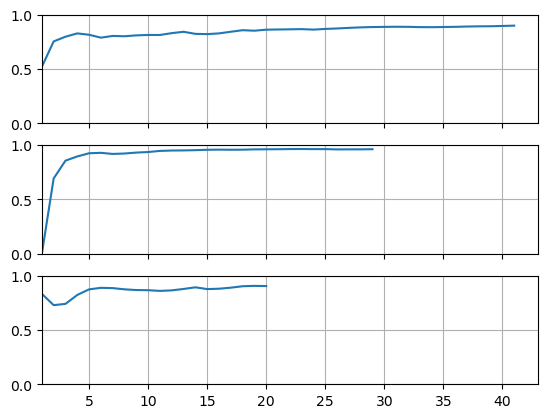

In [19]:
_, axes = plt.subplots(3,1, sharex=True)
profiles =[9,11,18]
for i in range(3):
    axes[i].plot(NHHI_series.iloc[profiles[i]])
    axes[i].grid()
    axes[i].set_ylim([0,1])
    axes[i].set_xlim(1)

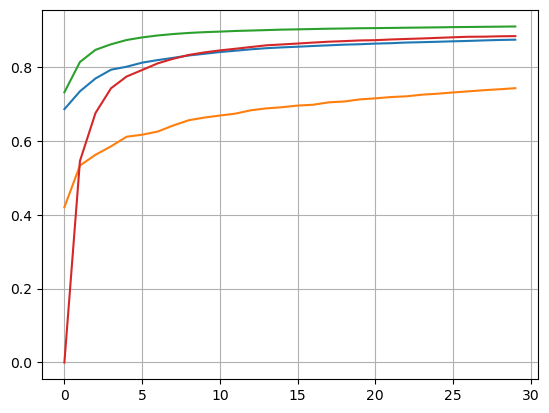

In [20]:
NHHI_series_arr = NHHI_series.drop(columns=np.arange(31,51)).dropna().to_numpy()

GMM = GaussianMixture(n_components=4, n_init=20, random_state=1).fit(NHHI_series_arr)
plt.plot(GMM.means_.T)
plt.grid()

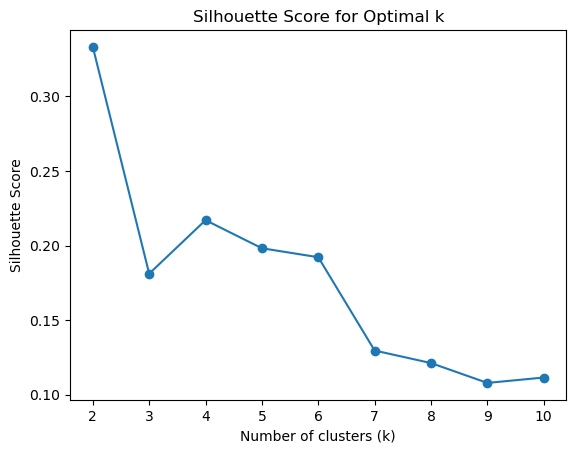

In [21]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, n_init=20, random_state=1)
    labels = kmeans.fit_predict(NHHI_series_arr)
    silhouette_scores.append(silhouette_score(NHHI_series_arr, labels))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()